In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

from boic import Caster, BoTorchMethod, BoTorchSettings, Results

In [2]:
class BOResults(Results):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.methods.dict['botorch'] = BoTorchMethod(BoTorchSettings())

In [3]:
ACQ_FN = 'rosenb'
DIM = 100
N_ACQS = 100
r = BOResults(file_filter=lambda x: f'E{ACQ_FN},D{DIM}' in x and (f'NM{N_ACQS}' in x if N_ACQS != 200 else True))
r.aggregate(overwrite=True, verbose=True)

@ botorch
NAME:  Rosenbrock,D100::TMlog::NM100::Kck
Saved agg file: Rosenbrock,D100::TMlog::NM100::Kck@botorch

NAME:  Rosenbrock,D100::TMlog::NM100::Kik,KMfixed,Rkii0.1,Ls
Saved agg file: Rosenbrock,D100::TMlog::NM100::Kik,KMfixed,Rkii0.1,Ls@botorch

NAME:  Rosenbrock,D100::TMlog::NM100::Kik,KMgreedy,Rkii0.1,Ls
Saved agg file: Rosenbrock,D100::TMlog::NM100::Kik,KMgreedy,Rkii0.1,Ls@botorch

NAME:  Rosenbrock,D100::TMlog::NM100::Ksk
Saved agg file: Rosenbrock,D100::TMlog::NM100::Ksk@botorch

NAME:  Rosenbrock,D100::TMlog::NM100::MMquadfhs,Ksk
Saved agg file: Rosenbrock,D100::TMlog::NM100::MMquadfhs,Ksk@botorch

NAME:  Rosenbrock,D100::TMlog::NM100,Ftrgreedyei::Kik,KMgreedy,Rkii0.1,Ls
Saved agg file: Rosenbrock,D100::TMlog::NM100,Ftrgreedyei::Kik,KMgreedy,Rkii0.1,Ls@botorch

NAME:  Rosenbrock,D100::TMlog::NM100,Ftrgreedyei::Ksk
Saved agg file: Rosenbrock,D100::TMlog::NM100,Ftrgreedyei::Ksk@botorch



In [4]:
def show_line_plot(plotter, fns, dims=[20, 50, 100], labels=None, colors=None, linewidth=4, figsize=None, legend_id=None, legend_loc=2, legend_size=22, legend_kws=None, show_legend=True, axes=None,
                   ylim=[0, 1.], savefig=None, tight_layout=True, xaxis_major_locator=20, disp='mean', callback_axes=None, **kwargs):
    plot_fns = Caster.to_list(fns)
    plot_dims = Caster.to_list(dims)
    plot_keys = plot_keys = [f"{a},D{b}" for a, b in itertools.product(plot_fns, plot_dims)]
    if axes is None:
        fig, axes = plt.subplots(len(plot_fns), len(plot_dims), figsize=(figsize or (len(plot_dims) * 10, len(plot_fns)*  8)))
    axes = list(Caster.collapse(axes))
    for i, (ax, key) in enumerate(zip(axes, plot_keys)):
        p = plotter[key]
        p.line_plot(ax=ax, colors=colors, ylim=ylim, disp=disp, **kwargs)
        if i < len(plot_dims):
             ax.set_xlabel(None)
        if i % len(plot_dims) != 0:
            ax.set_ylabel(None)
            ax.yaxis.set_ticklabels([])
        else:
            ax.yaxis.label.set_size(20)
        if not show_legend or ((legend_id is None and i % len(plot_dims) != len(plot_dims) - 1) or (legend_id is not None and legend_id != i)):
            ax.legend().set_visible(False)
        else:
            handles, olabels = ax.get_legend_handles_labels()
            if labels:
                handles = {la: ha for ha, la in zip(*ax.get_legend_handles_labels())}
                print(handles.keys())
                handles = [handles[la] for la in labels]
            else:
                labels = olabels 
            leg = ax.legend(handles, labels, loc=legend_loc, prop={'size': legend_size}, **(legend_kws or {}))
            for line in leg.get_lines():
                line.set_linewidth(linewidth)

        ax.title._fontproperties._size = 25
        ax.title._fontproperties._weight = 'bold'
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=20)
        ax.title._text = ax.title._text.replace(',D', ',') + 'D'
        ax.xaxis.set_major_locator(MultipleLocator(xaxis_major_locator))
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.get_label().set_fontsize(25)
        for line in ax.get_lines():
            line.set_linewidth(linewidth)
    if callback_axes is not None:
        callback_axes(axes)
    if savefig:
        if tight_layout:
            plt.tight_layout()
        plt.savefig(f'{savefig}.pdf', bbox_inches='tight')

In [5]:
labels = {'Ksk': 'S',
          'MMquadfhs,Ksk': 'S+QM',
          'Ftrgreedyei::Ksk': 'S+TR',
          'Kck': 'C',
          'Kik,KMfixed,Rkii0.1,Ls': 'I+X0 (Proposed)',
          'Kik,KMgreedy,Rkii0.1,Ls': 'I+XA (Proposed)',
          'Ftrgreedyei::Kik,KMgreedy,Rkii0.1,Ls': 'I+XA+TR (Proposed)',
         } 
label_to_alias = {'Rosenbrock': 'rosenb'}
colors = {'S': 'k',
          'S+QM': 'tab:brown',
          'S+TR': 'gray',
          'C': 'tab:olive',
          'I+X0 (Proposed)': 'tab:orange',
          'I+XA (Proposed)': 'tab:red',
          'I+XA+TR (Proposed)': 'forestgreen',
         }

eval_fns = ['Rosenbrock']
dims = [100]
eval_names = [f"{a},D{b}" for a, b in itertools.product(eval_fns, dims)]

plotter = {}
def aggfile_to_kw(fname):
    kw = fname.split('::')[-1].split('@botorch')[0]
    if 'Ftrgreedyei' in fname:
        kw = f'Ftrgreedyei::{kw}'
    return kw

for en in eval_names:
    ef = en.split(',')[0]
    ef = label_to_alias.get(ef, ef)
    def file_filter(x):
        if 'TMlog' not in x and '@botorch' not in x:
            return false
        return aggfile_to_kw(x) in labels.keys()
    def aliaser(name, **kwargs):
        return labels.get(aggfile_to_kw(name), name)
    plotter[en] = BOResults(file_filter=file_filter, aliaser=aliaser).load(en)

dict_keys(['C', 'I+X0 (Proposed)', 'I+XA (Proposed)', 'I+XA+TR (Proposed)', 'S', 'S+QM', 'S+TR'])


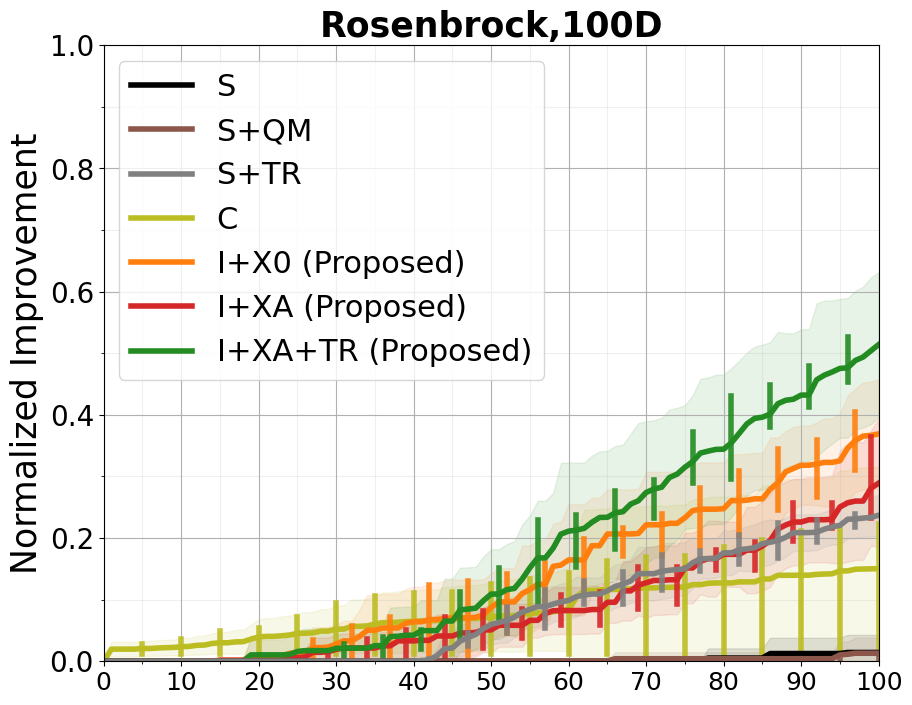

In [6]:
show_line_plot(plotter, fns='Rosenbrock', dims=[100], labels=labels.values(), colors=colors,
               xaxis_major_locator=10, error_x_interval=5, error_x_between=2, show_legend=True)